#  Load and clean the dataset

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/facebook-ad-campaign/data.csv')  

# Step 1: Drop 'age' and 'gender' columns and remove NaN values
 # Ensure no KeyError if columns don't exist
df = df.dropna()  # Remove rows with NaN values

# Check the cleaned dataset
print("Cleaned DataFrame: ")
print(df.head())

Cleaned DataFrame: 
    ad_id reporting_start reporting_end campaign_id fb_campaign_id    age  \
0  708746      17/08/2017    17/08/2017         916         103916  30-34   
1  708749      17/08/2017    17/08/2017         916         103917  30-34   
2  708771      17/08/2017    17/08/2017         916         103920  30-34   
3  708815      30/08/2017    30/08/2017         916         103928  30-34   
4  708818      17/08/2017    17/08/2017         916         103928  30-34   

  gender  interest1  interest2  interest3  impressions  clicks  spent  \
0      M         15         17         17       7350.0       1   1.43   
1      M         16         19         21      17861.0       2   1.82   
2      M         20         25         22        693.0       0   0.00   
3      M         28         32         32       4259.0       1   1.25   
4      M         28         33         32       4133.0       1   1.29   

   total_conversion  approved_conversion  
0               2.0                

FeatureScaling:

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['impressions', 'clicks', 'spent', 'total_conversion']] = scaler.fit_transform(df[['impressions', 'clicks', 'spent', 'total_conversion']])

CTR using the formula:

𝐶
𝑇
𝑅
=
(
clicks
impressions
)
×
100
CTR=( 
impressions
clicks
​
 )×100

In [3]:
# Calculate Click-Through Rate (CTR)
df['ctr'] = (df['clicks'] / df['impressions']) * 100

# Check the dataset after adding the 'ctr' column
print(df[['impressions', 'clicks', 'ctr']].head())

   impressions    clicks         ctr
0    -0.389356 -0.438620  112.652519
1    -0.346647 -0.408033  117.708759
2    -0.416406 -0.469206  112.679958
3    -0.401916 -0.438620  109.132149
4    -0.402428 -0.438620  108.993308


Installing necessary libraries

* Creating graph structure

In [4]:
pip install torch torch_geometric networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Assuming you have your full dataset in a dataframe called df
from sklearn.model_selection import train_test_split

# Splitting the data (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Now, train_df and test_df are correctly defined

In [6]:
print(train_df.columns)
print(test_df.columns)

Index(['ad_id', 'reporting_start', 'reporting_end', 'campaign_id',
       'fb_campaign_id', 'age', 'gender', 'interest1', 'interest2',
       'interest3', 'impressions', 'clicks', 'spent', 'total_conversion',
       'approved_conversion', 'ctr'],
      dtype='object')
Index(['ad_id', 'reporting_start', 'reporting_end', 'campaign_id',
       'fb_campaign_id', 'age', 'gender', 'interest1', 'interest2',
       'interest3', 'impressions', 'clicks', 'spent', 'total_conversion',
       'approved_conversion', 'ctr'],
      dtype='object')


Creating Graph:

In [7]:
import torch
import networkx as nx
from torch_geometric.data import Data

def create_graph_data(df):
    # Step 1: Create a mapping of ad_id to continuous indices
    unique_ad_ids = df['ad_id'].unique()
    ad_id_to_idx = {ad_id: idx for idx, ad_id in enumerate(unique_ad_ids)}
    
    # Step 2: Create the graph structure using networkx
    G = nx.Graph()

    # Add nodes (with continuous indices)
    G.add_nodes_from(range(len(unique_ad_ids)))

    # Add edges between ads that belong to the same campaign
    edges = []
    for i, row in df.iterrows():
        ad_idx = ad_id_to_idx[row['ad_id']]  # Use the mapped index
        campaign_ads = df[df['campaign_id'] == row['campaign_id']]['ad_id'].values
        for other_ad in campaign_ads:
            if row['ad_id'] != other_ad:
                edges.append((ad_idx, ad_id_to_idx[other_ad]))  # Use mapped indices for edges
    
    G.add_edges_from(edges)

    # Step 3: Convert to PyTorch Geometric Data object
    x = torch.tensor(df[['impressions', 'clicks', 'spent', 'total_conversion']].values, dtype=torch.float)  # Node features
    y = torch.tensor(df['ctr'].values, dtype=torch.float).unsqueeze(1)  # Target CTR
    edge_index = torch.tensor(list(G.edges)).t().contiguous()  # Edge index with continuous indices

    return Data(x=x, edge_index=edge_index, y=y)

# Create graph data for train and test sets with remapped node indices
train_graph_data = create_graph_data(train_df)
test_graph_data = create_graph_data(test_df)

* Defining the model

In [8]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)  # First GCN layer
        self.conv2 = GCNConv(16, out_channels)  # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(in_channels=4, out_channels=1)  # 4 input features -> 1 output (CTR)

* Training the model with MSE loss

Initialize the model, loss function, and optimizer

In [9]:
import torch.optim as optim

# Define your model, criterion, and optimizer
model = GCN(in_channels=4, out_channels=1) 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

* Training the model

In [10]:
# Step 6: Train the model
def train(model, train_data, optimizer, criterion, epochs=200):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output = model(train_data)
        
        # Calculate loss
        loss = criterion(output, train_data.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Start training the model
train(model, train_graph_data, optimizer, criterion)

Epoch 0, Loss: 516571.90625
Epoch 10, Loss: 515800.15625
Epoch 20, Loss: 515022.9375
Epoch 30, Loss: 514095.0625
Epoch 40, Loss: 512978.0
Epoch 50, Loss: 511692.9375
Epoch 60, Loss: 510309.90625
Epoch 70, Loss: 508926.46875
Epoch 80, Loss: 507648.53125
Epoch 90, Loss: 506566.0625
Epoch 100, Loss: 505726.46875
Epoch 110, Loss: 505121.09375
Epoch 120, Loss: 504694.25
Epoch 130, Loss: 504377.90625
Epoch 140, Loss: 504124.59375
Epoch 150, Loss: 503915.15625
Epoch 160, Loss: 503746.375
Epoch 170, Loss: 503617.375
Epoch 180, Loss: 503524.9375
Epoch 190, Loss: 503462.90625


Minmax scaling:

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the features (excluding target column 'ctr')
df[['impressions', 'clicks', 'spent', 'total_conversion']] = scaler.fit_transform(
    df[['impressions', 'clicks', 'spent', 'total_conversion']]
)

In [12]:
# Create the graph data again after scaling
train_graph_data = create_graph_data(train_df)
test_graph_data = create_graph_data(test_df)

Increasing the model complexity:

In [13]:
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, 32)  # Increased number of hidden units
        self.conv3 = GCNConv(32, out_channels)  # Adding another layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)  # Pass through additional layer
        return x

Initialize the model, loss function, and optimizer

In [14]:
model = GCN(in_channels=4, out_channels=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjusted learning rate

In [15]:
train(model, train_graph_data, optimizer, criterion)

Epoch 0, Loss: 516853.84375
Epoch 10, Loss: 516673.84375
Epoch 20, Loss: 516512.46875
Epoch 30, Loss: 516359.0625
Epoch 40, Loss: 516213.3125
Epoch 50, Loss: 516059.75
Epoch 60, Loss: 515894.9375
Epoch 70, Loss: 515714.3125
Epoch 80, Loss: 515500.84375
Epoch 90, Loss: 515249.84375
Epoch 100, Loss: 514955.21875
Epoch 110, Loss: 514611.0
Epoch 120, Loss: 514211.6875
Epoch 130, Loss: 513752.0625
Epoch 140, Loss: 513229.0625
Epoch 150, Loss: 512642.3125
Epoch 160, Loss: 511994.9375
Epoch 170, Loss: 511294.46875
Epoch 180, Loss: 510552.09375
Epoch 190, Loss: 509777.40625


Modifying the code:

In [16]:
# New modifications for training
learning_rate = 0.0001  # Updated learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Reinitialize optimizer

# Updated training function
def train_updated(model, train_data, optimizer, criterion, epochs=300):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output = model(train_data)
        
        # Calculate loss
        loss = criterion(output, train_data.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Start training the model again with updated parameters
train_updated(model, train_graph_data, optimizer, criterion)

Epoch 0, Loss: 508983.6875
Epoch 10, Loss: 508934.84375
Epoch 20, Loss: 508885.90625
Epoch 30, Loss: 508836.90625
Epoch 40, Loss: 508788.0625
Epoch 50, Loss: 508739.0625
Epoch 60, Loss: 508690.15625
Epoch 70, Loss: 508641.25
Epoch 80, Loss: 508592.21875
Epoch 90, Loss: 508543.25
Epoch 100, Loss: 508494.21875
Epoch 110, Loss: 508445.15625
Epoch 120, Loss: 508396.21875
Epoch 130, Loss: 508347.25
Epoch 140, Loss: 508298.40625
Epoch 150, Loss: 508249.53125
Epoch 160, Loss: 508200.75
Epoch 170, Loss: 508151.9375
Epoch 180, Loss: 508103.15625
Epoch 190, Loss: 508054.53125
Epoch 200, Loss: 508005.9375
Epoch 210, Loss: 507957.375
Epoch 220, Loss: 507908.9375
Epoch 230, Loss: 507860.625
Epoch 240, Loss: 507812.25
Epoch 250, Loss: 507764.21875
Epoch 260, Loss: 507716.09375
Epoch 270, Loss: 507668.21875
Epoch 280, Loss: 507620.40625
Epoch 290, Loss: 507572.75


Updated training function to store loss values:

Epoch 0, Loss: 507525.15625
Epoch 10, Loss: 507477.78125
Epoch 20, Loss: 507430.53125
Epoch 30, Loss: 507383.3125
Epoch 40, Loss: 507336.40625
Epoch 50, Loss: 507289.6875
Epoch 60, Loss: 507243.09375
Epoch 70, Loss: 507196.6875
Epoch 80, Loss: 507150.40625
Epoch 90, Loss: 507104.40625
Epoch 100, Loss: 507058.59375
Epoch 110, Loss: 507013.0
Epoch 120, Loss: 506967.59375
Epoch 130, Loss: 506922.46875
Epoch 140, Loss: 506877.59375
Epoch 150, Loss: 506832.78125
Epoch 160, Loss: 506788.40625
Epoch 170, Loss: 506744.21875
Epoch 180, Loss: 506700.25
Epoch 190, Loss: 506656.53125
Epoch 200, Loss: 506613.15625
Epoch 210, Loss: 506570.0625
Epoch 220, Loss: 506527.09375
Epoch 230, Loss: 506484.59375
Epoch 240, Loss: 506442.25
Epoch 250, Loss: 506400.3125
Epoch 260, Loss: 506358.625
Epoch 270, Loss: 506317.3125
Epoch 280, Loss: 506276.21875
Epoch 290, Loss: 506235.46875


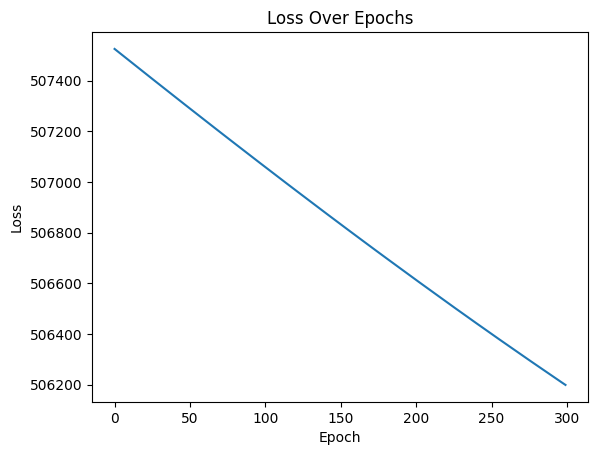

In [17]:
import matplotlib.pyplot as plt
def train_with_visualization(model, train_data, optimizer, criterion, epochs=300):
    loss_values = []  # List to store loss values for plotting
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output = model(train_data)
        
        # Calculate loss
        loss = criterion(output, train_data.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        loss_values.append(loss.item())  # Store the loss
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Plotting the loss over epochs
    plt.plot(loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.show()

# Start training the model again with updated parameters
train_with_visualization(model, train_graph_data, optimizer, criterion)

Modified training:

Checking the data:

In [18]:
# Step 1: Split test_df into validation and test sets (e.g., 50-50 split)
val_df = test_df.sample(frac=0.5, random_state=42)
test_df = test_df.drop(val_df.index)

# Step 2: Create graph data for the validation set
val_graph_data = create_graph_data(val_df)

# Step 3: Checking the data for both training and validation sets
print("Training Data:")
print("Number of Nodes:", train_graph_data.num_nodes)
print("Number of Edges:", train_graph_data.num_edges)
print("Node Features Shape:", train_graph_data.x.shape)
print("Edge Index Shape:", train_graph_data.edge_index.shape)

print("\nValidation Data:")
print("Number of Nodes:", val_graph_data.num_nodes)
print("Number of Edges:", val_graph_data.num_edges)
print("Node Features Shape:", val_graph_data.x.shape)
print("Edge Index Shape:", val_graph_data.edge_index.shape)

Training Data:
Number of Nodes: 608
Number of Edges: 87607
Node Features Shape: torch.Size([608, 4])
Edge Index Shape: torch.Size([2, 87607])

Validation Data:
Number of Nodes: 76
Number of Edges: 1387
Node Features Shape: torch.Size([76, 4])
Edge Index Shape: torch.Size([2, 1387])


# **Final model implementation**

In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np
from sklearn.model_selection import train_test_split

# Example Graph Neural Network Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Function to remap edge indices
def remap_edge_index(edge_index, node_indices):
    node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(node_indices.tolist())}
    remapped_edge_index = edge_index.clone()
    
    mask = torch.zeros(edge_index.size(1), dtype=torch.bool)
    
    for i in range(edge_index.size(1)):
        src, dst = edge_index[:, i]
        if src.item() in node_mapping and dst.item() in node_mapping:
            remapped_edge_index[0, i] = node_mapping[src.item()]
            remapped_edge_index[1, i] = node_mapping[dst.item()]
            mask[i] = True
            
    return remapped_edge_index[:, mask], mask.sum()  # Return only valid edges

# Function to create graph data
def create_graph_data(complete_node_features, complete_edge_index, target_values, train_indices, val_indices):
    # Split the complete data into training and validation sets
    train_node_indices = train_indices
    val_node_indices = val_indices

    # Create the training edge index
    train_edge_index, train_valid_count = remap_edge_index(complete_edge_index, train_node_indices)

    # Only create the training graph data if there are valid edges
    if train_valid_count > 0:
        train_graph_data = Data(x=complete_node_features[train_node_indices],
                                 edge_index=train_edge_index,
                                 y=target_values[train_node_indices])
    else:
        raise ValueError("No valid training edges found!")

    # Create the validation edge index
    val_edge_index, val_valid_count = remap_edge_index(complete_edge_index, val_node_indices)

    # Only create the validation graph data if there are valid edges
    if val_valid_count > 0:
        val_graph_data = Data(x=complete_node_features[val_node_indices],
                              edge_index=val_edge_index,
                              y=target_values[val_node_indices])
    else:
        raise ValueError("No valid validation edges found!")

    return train_graph_data, val_graph_data

# Example data creation (replace with actual data)
num_nodes = 1000
num_features = 10
num_classes = 1
np.random.seed(42)

# Create dummy node features, edge index and target values
complete_node_features = torch.rand((num_nodes, num_features))
complete_edge_index = torch.randint(0, num_nodes, (2, 5000))  # Random edges
target_values = torch.rand((num_nodes, num_classes))

# Split data into training and validation indices
train_indices, val_indices = train_test_split(np.arange(num_nodes), test_size=0.2, random_state=42)

# Create graph data
train_graph_data, val_graph_data = create_graph_data(complete_node_features, complete_edge_index, target_values, train_indices, val_indices)

# Create DataLoaders
train_loader = DataLoader([train_graph_data], batch_size=32, shuffle=True)
val_loader = DataLoader([val_graph_data], batch_size=32, shuffle=False)

# Initialize model, optimizer and loss function
model = GCN(in_channels=num_features, hidden_channels=16, out_channels=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training and Evaluation Function
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []
    val_predictions = []
    val_true_values = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch.y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                output = model(batch)
                loss = criterion(output, batch.y)
                epoch_val_loss += loss.item()
                val_predictions.append(output.numpy())
                val_true_values.append(batch.y.numpy())

        val_losses.append(epoch_val_loss / len(val_loader))

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses, val_predictions, val_true_values

# Train the model
train_losses, val_losses, val_predictions, val_true_values = train_and_evaluate(
    model, train_loader, val_loader, optimizer, criterion, epochs=100
)

# Convert the predictions and true values back to arrays for evaluation
val_predictions = np.concatenate(val_predictions).squeeze()
val_true_values = np.concatenate(val_true_values).squeeze()

# Print final evaluation results
print("Final Validation Predictions:", val_predictions)
print("Final Validation True Values:", val_true_values)

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/100, Train Loss: 1.0983, Val Loss: 0.7727
Epoch 2/100, Train Loss: 0.6334, Val Loss: 0.4124
Epoch 3/100, Train Loss: 0.3268, Val Loss: 0.2160
Epoch 4/100, Train Loss: 0.1598, Val Loss: 0.1576
Epoch 5/100, Train Loss: 0.1121, Val Loss: 0.1987
Epoch 6/100, Train Loss: 0.1547, Val Loss: 0.2590
Epoch 7/100, Train Loss: 0.2142, Val Loss: 0.2950
Epoch 8/100, Train Loss: 0.2496, Val Loss: 0.3001
Epoch 9/100, Train Loss: 0.2574, Val Loss: 0.2820
Epoch 10/100, Train Loss: 0.2457, Val Loss: 0.2514
Epoch 11/100, Train Loss: 0.2223, Val Loss: 0.2164
Epoch 12/100, Train Loss: 0.1940, Val Loss: 0.1838
Epoch 13/100, Train Loss: 0.1657, Val Loss: 0.1580
Epoch 14/100, Train Loss: 0.1410, Val Loss: 0.1403
Epoch 15/100, Train Loss: 0.1224, Val Loss: 0.1316
Epoch 16/100, Train Loss: 0.1111, Val Loss: 0.1309
Epoch 17/100, Train Loss: 0.1070, Val Loss: 0.1364
Epoch 18/100, Train Loss: 0.1087, Val Loss: 0.1454
Epoch 19/100, Train Loss: 0.1142, Val Loss: 0.1554
Epoch 20/100, Train Loss: 0.1212, Val Lo

Displaying Predictions:

Mean Squared Error (MSE): 0.1443
Root Mean Squared Error (RMSE): 0.3799
Mean Absolute Error (MAE): 0.3100


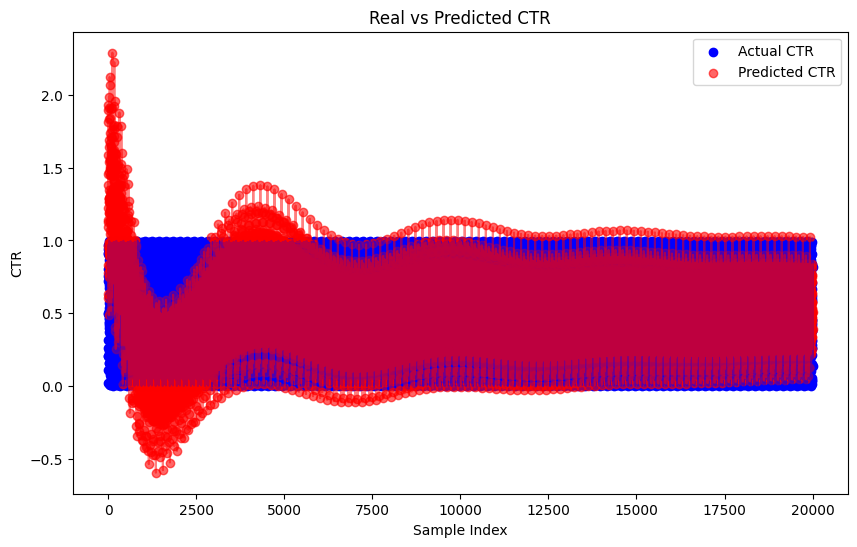

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Function to calculate and print RMSE, MSE, and accuracy
def evaluate_performance(val_predictions, val_true_values):
    # Calculate MSE and RMSE
    mse = mean_squared_error(val_true_values, val_predictions)
    rmse = np.sqrt(mse)
    
    # Accuracy calculation (assuming you're comparing regression predictions)
    mae = mean_absolute_error(val_true_values, val_predictions)
    
    # Print the results
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    return mse, rmse, mae

# Function to plot real vs predicted CTR values
def plot_real_vs_predicted(val_predictions, val_true_values):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(val_true_values)), val_true_values, color='blue', label='Actual CTR')
    plt.scatter(range(len(val_predictions)), val_predictions, color='red', label='Predicted CTR', alpha=0.6)
    plt.plot(range(len(val_true_values)), val_true_values, color='blue', alpha=0.5)  # To create a continuous curve for actual CTR
    plt.plot(range(len(val_predictions)), val_predictions, color='red', alpha=0.5)  # To create a continuous curve for predicted CTR
    plt.title("Real vs Predicted CTR")
    plt.xlabel("Sample Index")
    plt.ylabel("CTR")
    plt.legend()
    plt.show()

# After training, call the evaluation function and plot function
mse, rmse, mae = evaluate_performance(val_predictions, val_true_values)

# Plot the real vs predicted CTR values
plot_real_vs_predicted(val_predictions, val_true_values)